## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# calibration images has 9x6 inner corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## 2. UnDistort Images

Should now have objpoints and imgpoints needed for camera calibration. Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

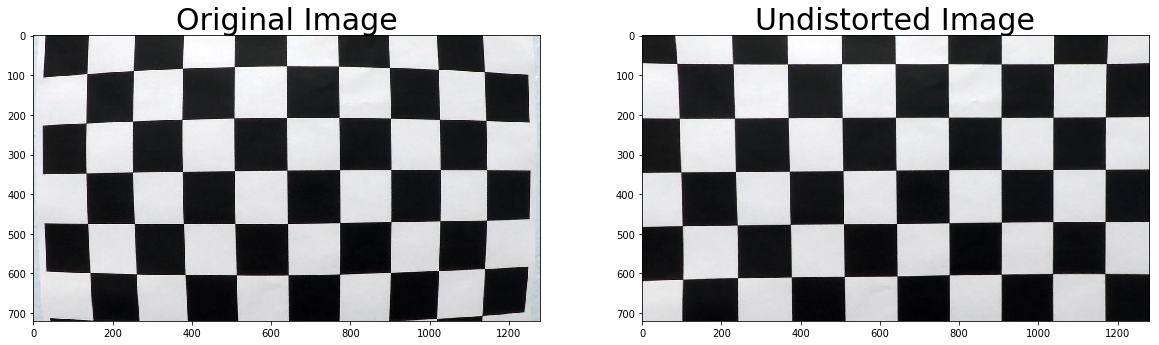

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/calibration_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [2]:
import numpy as np
import cv2

# Inputs:
#   img:
def colorAndGradientThresholdBinary(img, s_thresh=(170, 255), sx_thresh=(20, 100), ksize=3):
    """Use Sobel gradient and Color transforms to create a thresholded binary image

    Args:
        img (numpy.ndarrar): Source image.
        s_thresh (tuple): Color channel threshold. Two element tuple.
        sx_thresh (tuple): Sobel operator threshold. Two element tuple.
        ksize (int): Sobel operator kernel size.

    Returns:
        (color_binary, sxbinary, s_binary): color_binary, sxbinary, s_binary
    """
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    ### Sobel x
    # Take the derivative in x direction to accentuate vertical lines
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative
    abs_sobelx = np.absolute(sobelx)
    
    # convert to 8-bit
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary, sxbinary, s_binary
    

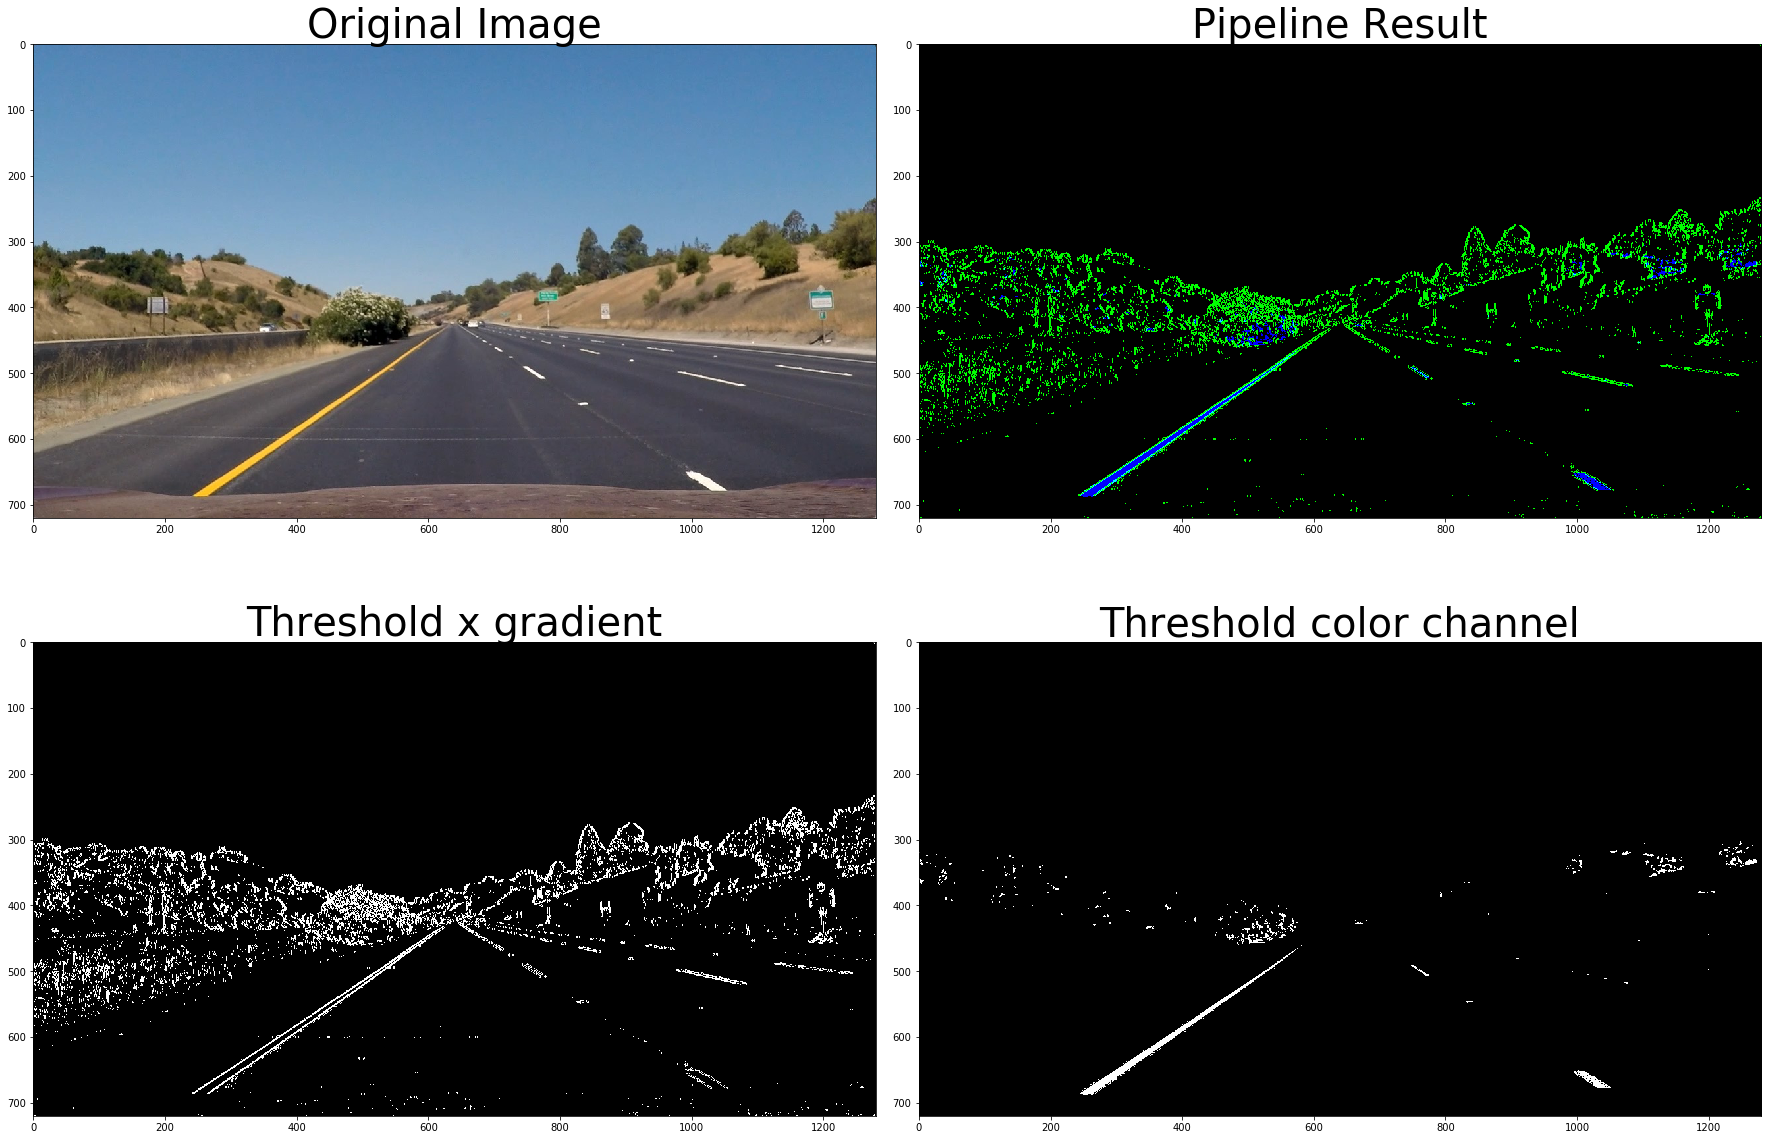

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# NOTE jpg and png format pixel values are different ranges? jpg = 8bit?
# image = mpimg.imread('./signs_vehicles_xygrad.png') 
image = mpimg.imread('./test_images/straight_lines1.jpg')

result, sxbinary, s_binary = colorAndGradientThresholdBinary(image)

# Plot the result
f, axes = plt.subplots(2, 2, squeeze=False, figsize=(24, 18))
f.tight_layout()

axes[0][0].imshow(image)
axes[0][0].set_title('Original Image', fontsize=40)

axes[0][1].imshow(result)
axes[0][1].set_title('Pipeline Result', fontsize=40)

axes[1][0].imshow(sxbinary, cmap='gray')
axes[1][0].set_title('Threshold x gradient', fontsize=40)

axes[1][1].imshow(s_binary, cmap='gray')
axes[1][1].set_title('Threshold color channel', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)